# Jadu Analysis - EDA

The aim of this notebook is:

1.- Deep dive analysis on Jadu creators use patterns regarding LLMs for all source of tasks such image, video and audio generation to uncover hidden findings and learning.

2.- Help the author of this notebook on his onboarding tasks of getting a better understanding of the company idiosyncrasy

In [135]:
import sys
from pathlib import Path
import pandas as pd
from src.mongo.mongo_db_client import get_collection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

# Softer, high-contrast palette (Tableau-like, no purple bias)
palette = [
    "#4E79A7",  # blue
    "#F28E2B",  # orange
    "#E15759",  # red
    "#76B7B2",  # teal
    "#59A14F",  # green
    "#EDC948",  # yellow
    "#B07AA1",  # muted violet
    "#FF9DA7",  # pink
    "#9C755F",  # brown
    "#BAB0AC",  # gray
]

## Load data

In [117]:
DB_NAME = 'renderboard'
COLLECTION_NAME = 'assetGenJobs'
COLLECTION = get_collection(DB_NAME, COLLECTION_NAME)
# Load dataframe from MongoDB collection
df = pd.json_normalize(COLLECTION.find(
        {},
    )
)


In [118]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 45601 entries, 0 to 45600
Columns: 109 entries, _id to modelConfig.modelMetaData.googleGeminiModelId
dtypes: datetime64[us](3), float64(8), int64(1), object(26), str(71)
memory usage: 37.9+ MB


In [ ]:
list_columns = list(df.columns)
for col in list_columns:
    print(col)

In [ ]:
### COLUMNS OF INTEREST (based on the above list and some manual inspection of the data):
# modelConfig.costConfig.defaultCost --> Cost of the job  
# modelConfig.costConfig.rules	--> Not sure, but seems to be a JSON with the cost breakdown of the job (e.g. compute time, storage, etc.) [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
# qualityAnalysis.score	--> Overall quality score (0-10)
# qualityAnalysis.reasoning --> Explanation of the quality score (25000+ unique values, very long text in some cases). Is it LLM-generated? Seems to be, as some entries are very similar except for the numbers (e.g. "The quality score is 7 because the generated image has good composition and color balance, but the details are somewhat lacking." vs "The quality score is 3 because the generated video has poor resolution and noticeable artifacts throughout.")
# qualityAnalysis.transformedScore	--> Unclear but transformation of the original scoring
# qualityAnalysis.rewrittenPrompt	--> Rewritten prompt to improve quality 
# resultDownloadedAt --> Proxy for quality !! If users download the result, it means they liked it. We can use this as a binary proxy for quality and see how it correlates with the qualityAnalysis.score and the cost of the job. We can also analyze the reasoning to see if there are common themes in high vs low quality jobs.

## Columns of interest
Based on the column list + manual inspection.

### Cost & pricing
- `modelConfig.costConfig.defaultCost` — Default cost of the job.
- `modelConfig.costConfig.rules` — Pricing rules by condition (likely a JSON list, e.g. duration → cost).  
  Example: `[{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, ...]`

### Quality signals
- `qualityAnalysis.score` — Overall quality score (0–10).
- `qualityAnalysis.reasoning` — Long-form explanation for the score (25k+ unique values).  
  Likely LLM-generated: many entries are structurally similar with different numbers.
- `qualityAnalysis.transformedScore` — Derived/normalized version of the original score (needs validation).
- `qualityAnalysis.rewrittenPrompt` — Prompt rewritten to improve quality.

### Behavioral proxy
- `resultDownloadedAt` — Proxy for user satisfaction.  
  If a user downloads the result, we can treat it as a positive outcome and compare it against:
  - `qualityAnalysis.score`
  - `modelConfig.costConfig.defaultCost`
  - recurring themes in `qualityAnalysis.reasoning`


- `jobMetaData.*` --> All the columns are empty ('jobMetaData.storyId','jobMetaData.sceneId','jobMetaData.isSketchToShotImage'...)



## Feature enginnering

In [120]:
# Date transformations 

df['dt'] = pd.to_datetime(df['createdAt']).dt.strftime('%Y-%m-%d')
# Also the isoweek and isoyear might be useful for time series analysis
df_isocal = pd.to_datetime(df['createdAt']).dt.isocalendar()
df['isoyear'] = df_isocal['year']   
# Isoweek date such as 2024-W27 is not very useful, let's convert it to a number such as 202427
df['isoweek'] = df_isocal.apply(lambda x: f"{x['year']}{x['week']:02d}", axis=1)

In [121]:
# Narrow down to the most common model types based on id and name
def classify_model_type(model_id, model_name):
    if 't2i' in model_id or 'Text to Image' in model_name:
        return 't2i'
    elif 'i2i' in model_id or 'Image to Image' in model_name:
        return 'i2i'
    elif 'i2v' in model_id or 'Image to Video' in model_name:
        return 'i2v'
    elif 'v2v' in model_id or 'Video to Video' in model_name:
        return 'v2v'
    elif 't2v' in model_id or 'Text to Video' in model_name:
        return 't2v'
    elif 't2s' in model_id or 'Text to Speech' in model_name:
        return 't2s'
    elif 's2v' in model_id or 'Speech to Video' in model_name:
        return 's2v'
    elif 'Minimatics' in model_name:
        return 'minimatics'
    elif 'Character Models' in model_name:
        return 'character_models'
    elif 'Sound Effects' in model_name:
        return 'sound_effects'
    else:
        return 'unknown'
df['model_type'] = df.apply(lambda row: classify_model_type(row['modelConfig.id'], row['modelConfig.name']), axis=1)

#### Job type

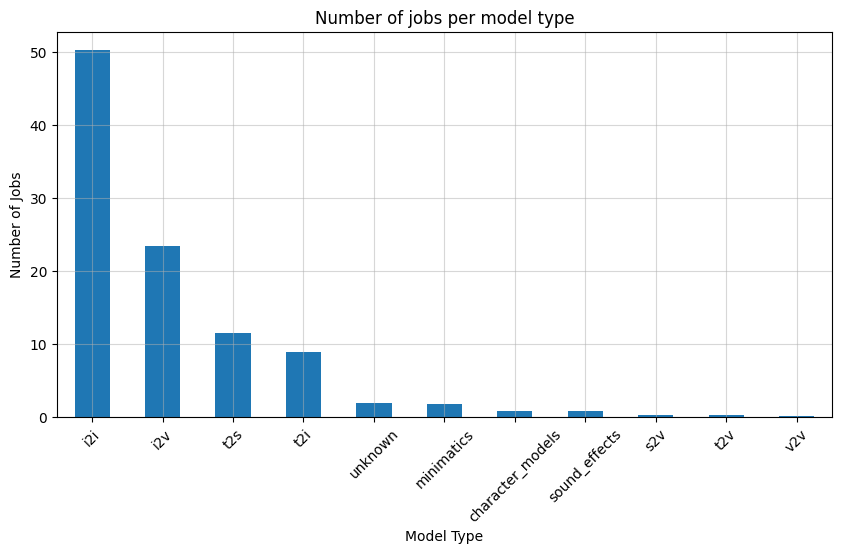

In [122]:
# First of all models per category
df_cat = 100*df['model_type'].value_counts(normalize=True)
plt.figure(figsize=(10, 5))
df_cat.plot(kind='bar')
plt.title('Number of jobs per model type')
plt.xlabel('Model Type')
plt.ylabel('Number of Jobs')
plt.grid(alpha=0.5)
plt.xticks(rotation=45)
plt.show()


In [ ]:
'i2i','i2v','t2s','t2i'

In [131]:
df_ts_type_raw = df.groupby(['isoweek','model_type']).size().unstack().fillna(0)
df_ts_type_raw_dist = 100*df_ts_type_raw.div(df_ts_type_raw.sum(axis=1), axis=0)
round(df_ts_type_raw_dist.tail(),1)

model_type,character_models,i2i,i2v,minimatics,s2v,sound_effects,t2i,t2s,t2v,unknown,v2v
isoweek,,,,,,,,,,,
202604,0.0,52.2,27.7,0.8,0.1,0.0,3.2,15.0,0.0,1.0,0.0
202605,0.0,39.9,5.7,3.2,0.4,0.8,6.8,42.1,0.6,0.5,0.0
202606,0.0,80.1,10.2,2.7,0.0,0.0,6.6,0.3,0.0,0.1,0.0
202607,0.0,31.6,36.9,1.9,2.4,0.0,7.4,18.3,0.2,1.2,0.0
202608,0.0,55.1,12.0,0.0,0.0,0.0,19.2,13.0,0.0,0.7,0.0


In [132]:
# Aggregated model type to just show the main categories
df['model_type_agg'] = df['model_type'].apply(lambda x: x if x in ['t2i', 'i2i', 'i2v', 'v2v', 't2v'] else 'other')

In [133]:
df_ts_type = df.groupby(['isoweek','model_type_agg']).size().unstack().fillna(0)
df_ts_type_dist = 100*df_ts_type.div(df_ts_type.sum(axis=1), axis=0)
round(df_ts_type_dist.tail(),1)

model_type_agg,i2i,i2v,other,t2i,t2v,v2v
isoweek,,,,,,
202604,52.2,27.7,17.0,3.2,0.0,0.0
202605,39.9,5.7,47.1,6.8,0.6,0.0
202606,80.1,10.2,3.1,6.6,0.0,0.0
202607,31.6,36.9,23.9,7.4,0.2,0.0
202608,55.1,12.0,13.8,19.2,0.0,0.0


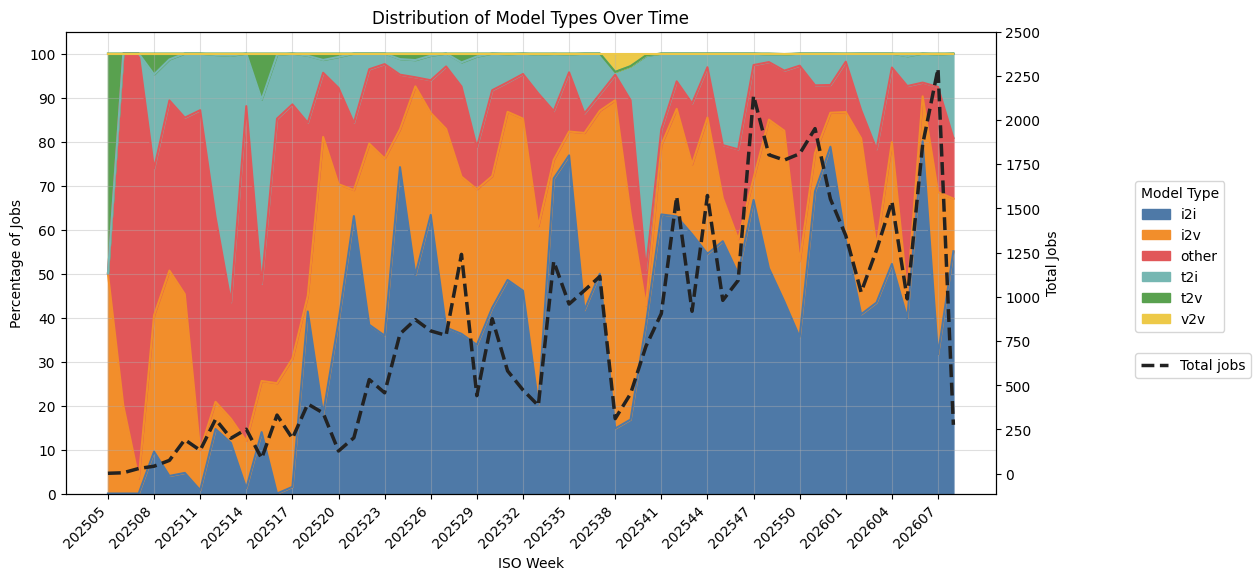

In [148]:
fig, ax = plt.subplots(figsize=(12, 6))

# area chart (percent)
df_ts_type_dist.plot(kind='area', ax=ax, stacked=True, color=palette[:df_ts_type_dist.shape[1]])
ax.set_title('Distribution of Model Types Over Time')
ax.set_xlabel('ISO Week')
ax.set_ylabel('Percentage of Jobs')
ax.set_yticks(range(0, 101, 10))
ax.legend(title='Model Type', loc=(1.15, 0.35))
ax.grid(alpha=0.4)


step = 3  # 1=every week, 2=every 2 weeks, etc.
x = np.arange(len(df_ts_type_dist.index))

ax.set_xticks(x[::step])
ax.set_xticklabels(df_ts_type_dist.index[::step].astype(str), rotation=45, ha="right")

# secondary axis (absolute totals)
ax2 = ax.twinx()
total_jobs = df_ts_type.sum(axis=1)
ax2.plot(total_jobs.index, total_jobs.values, color="#222222", linewidth=2.5, linestyle='--', label='Total jobs')
ax2.set_ylabel('Total Jobs')

# 250-step ticks
ymax = total_jobs.max()
ax2.set_yticks(range(0, int(ymax) + 251, 250))

ax2.legend(loc=(1.15, 0.25))

plt.show()


In [149]:
df_ts_type_cost = df.groupby(['isoweek','model_type_agg'])['modelConfig.costConfig.defaultCost'].sum().unstack().fillna(0)
df_ts_type_dist_cost = 100*df_ts_type_cost.div(df_ts_type_cost.sum(axis=1), axis=0)
round(df_ts_type_dist_cost.tail(),1)

model_type_agg,i2i,i2v,other,t2i,t2v,v2v
isoweek,,,,,,
202604,31.6,65.5,1.2,1.7,0.0,0.0
202605,53.5,29.8,4.3,8.7,3.7,0.0
202606,63.8,33.3,0.2,2.7,0.0,0.0
202607,17.3,74.6,5.6,1.8,0.7,0.0
202608,46.5,49.9,0.0,3.5,0.0,0.0


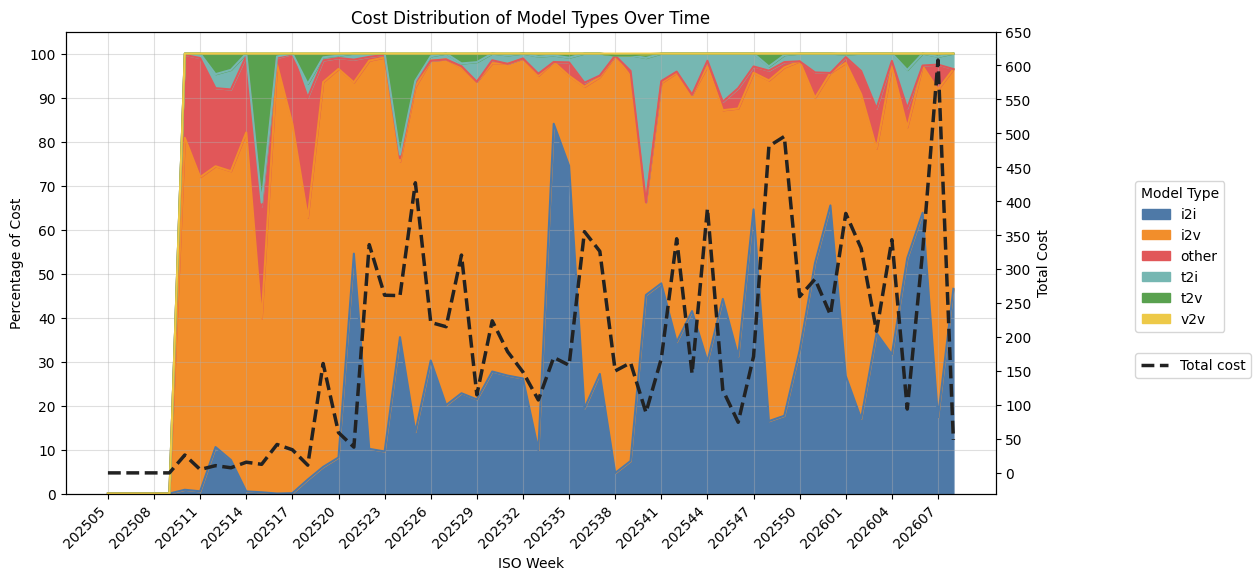

In [151]:
fig, ax = plt.subplots(figsize=(12, 6))

# area chart (percent)
df_ts_type_dist_cost.plot(kind='area', ax=ax, stacked=True, color=palette[:df_ts_type_dist_cost.shape[1]])
ax.set_title('Cost Distribution of Model Types Over Time')
ax.set_xlabel('ISO Week')
ax.set_ylabel('Percentage of Cost')
ax.set_yticks(range(0, 101, 10))
ax.legend(title='Model Type', loc=(1.15, 0.35))
ax.grid(alpha=0.4)


step = 3  # 1=every week, 2=every 2 weeks, etc.
x = np.arange(len(df_ts_type_dist_cost.index))

ax.set_xticks(x[::step])
ax.set_xticklabels(df_ts_type_dist_cost.index[::step].astype(str), rotation=45, ha="right")

# secondary axis (absolute totals)
ax2 = ax.twinx()
total_cost = df_ts_type_cost.sum(axis=1)
ax2.plot(total_cost.index, total_cost.values, color="#222222", linewidth=2.5, linestyle='--', label='Total cost')
ax2.set_ylabel('Total Cost')

# 250-step ticks
ymax = total_cost.max()
ax2.set_yticks(range(0, int(ymax) + 51, 50))

ax2.legend(loc=(1.15, 0.25))

plt.show()


# Models over time

## Models overtime

In [ ]:
# list_model_types = df['model_type'].value_counts().index.tolist() 
# for model_type in list_model_types:
#     # Let's make a cool visualization of the most common model titles for each model type per week
#     #print(f"Model type: {model_type}")
#     df_type = df[df['model_type'] == model_type]['modelConfig.modelTitle'].value_counts()
#     fig, ax = plt.subplots(figsize=(10, 5))
#     df_type.head(10).plot(kind='bar', ax=ax)
#     ax.set_title(f"Top 10 model titles for model type: {model_type}")
#     ax.set_xlabel("Model Title")
#     ax.set_ylabel("Count")
#     plt.xticks(rotation=45)
#     plt.show()


In [189]:
df_type_week = df[df['model_type'] == 'i2i'].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
df_type_week.tail()

modelConfig.modelTitle,Fal Nano Banana Pro,Flux Dev,Flux Kontext Pro,Flux Schnell,GPT Image 1,Google Nano Banana Pro,Image Edit,Image Edit OpenAI,Nano Banana,Nano Banana Pro,Replicate Nano Banana Pro,Shot Image,Shot Image OpenAI,Story Thumbnail,Story Thumbnail OpenAI
isoweek,,,,,,,,,,,,,,,
202604,563.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,77.0,0.0,156.0,0.0,0.0,0.0,0.0
202605,324.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,25.0,0.0,37.0,0.0,0.0,0.0,0.0
202606,1273.0,0.0,6.0,0.0,46.0,2.0,0.0,0.0,41.0,0.0,122.0,0.0,0.0,0.0,0.0
202607,614.0,0.0,2.0,0.0,5.0,48.0,0.0,0.0,27.0,0.0,28.0,0.0,0.0,0.0,0.0
202608,69.0,0.0,0.0,0.0,1.0,80.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


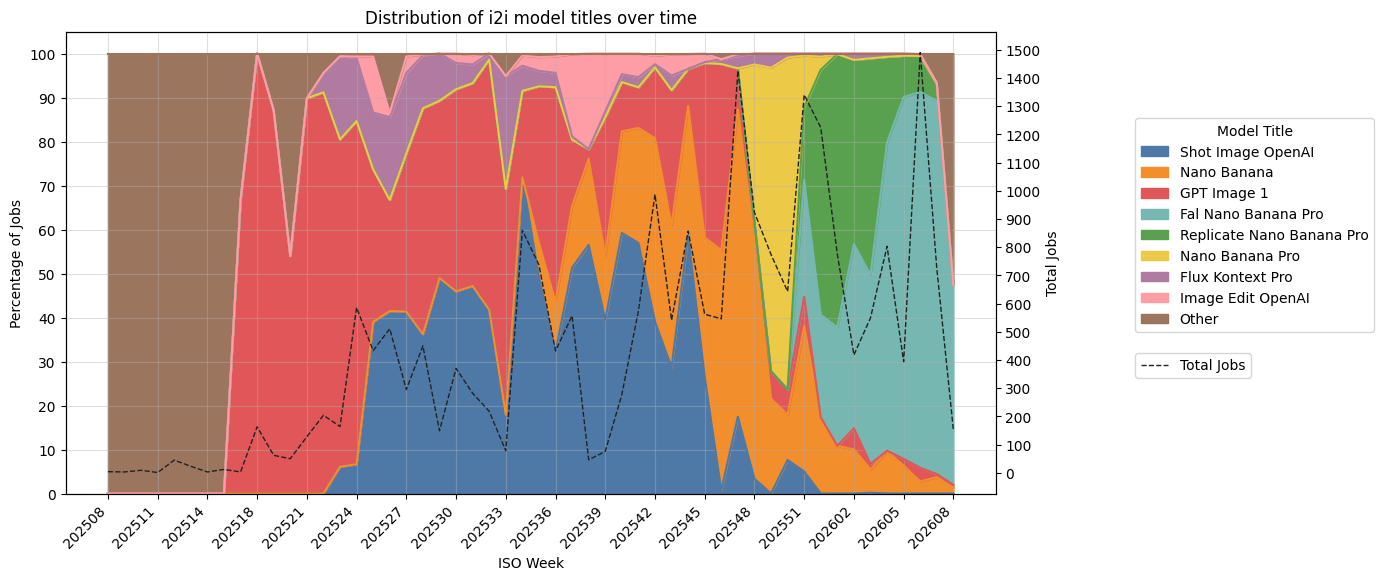

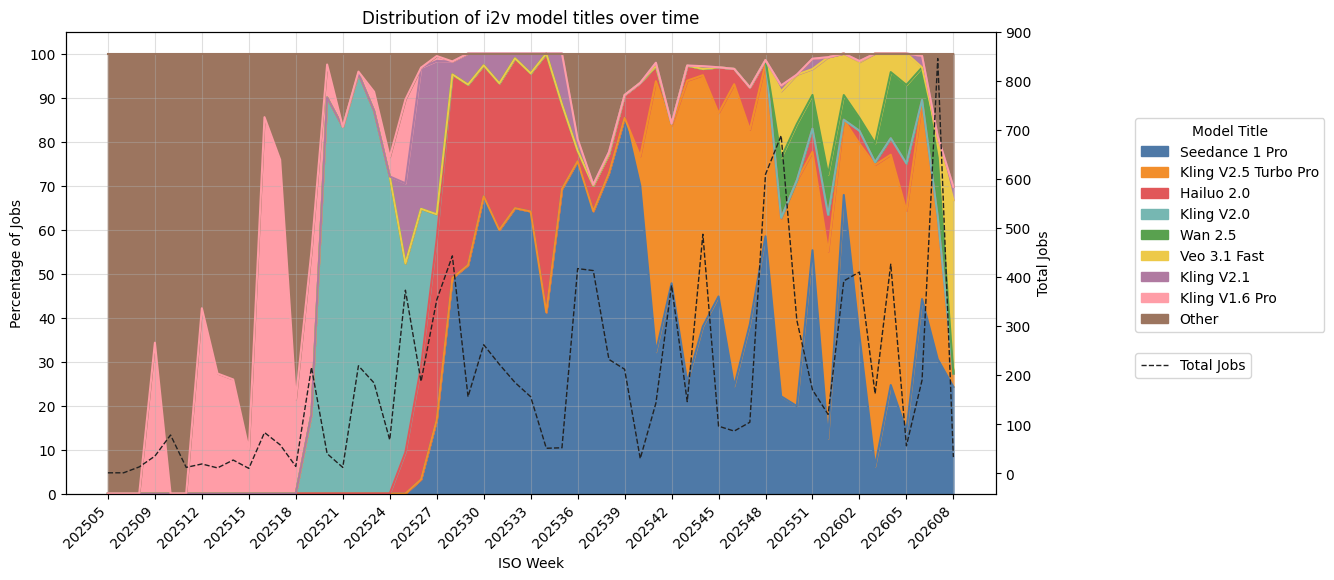

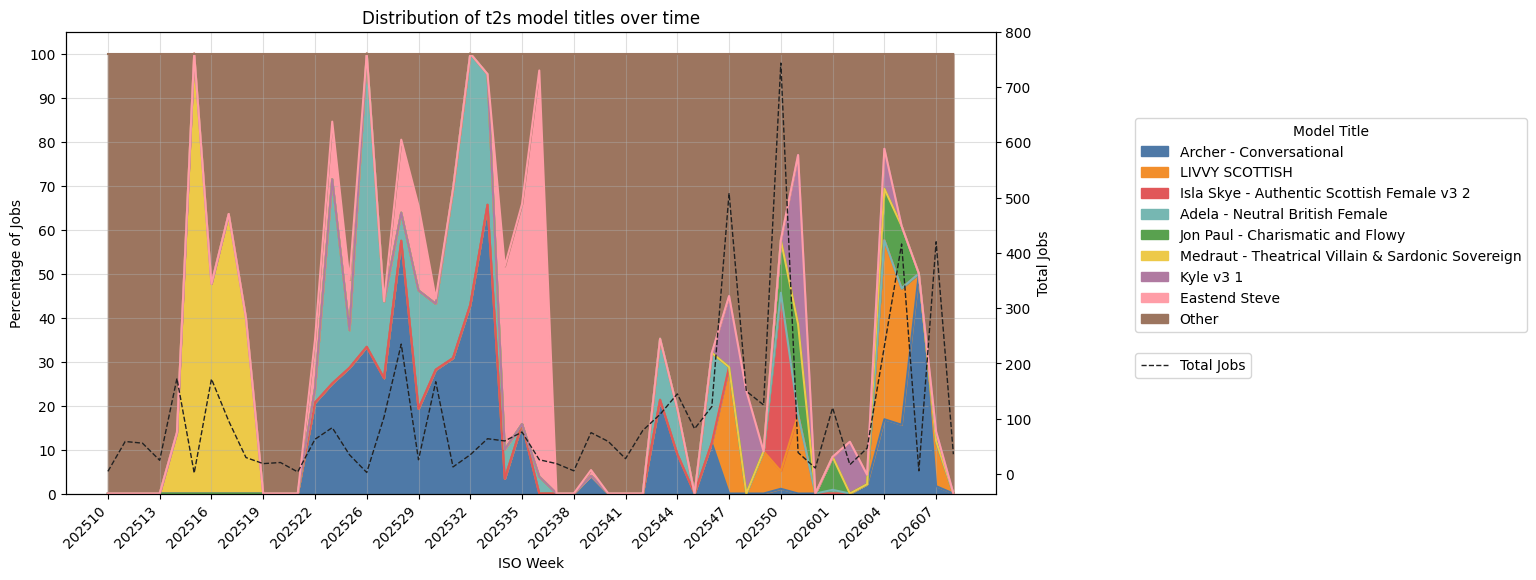

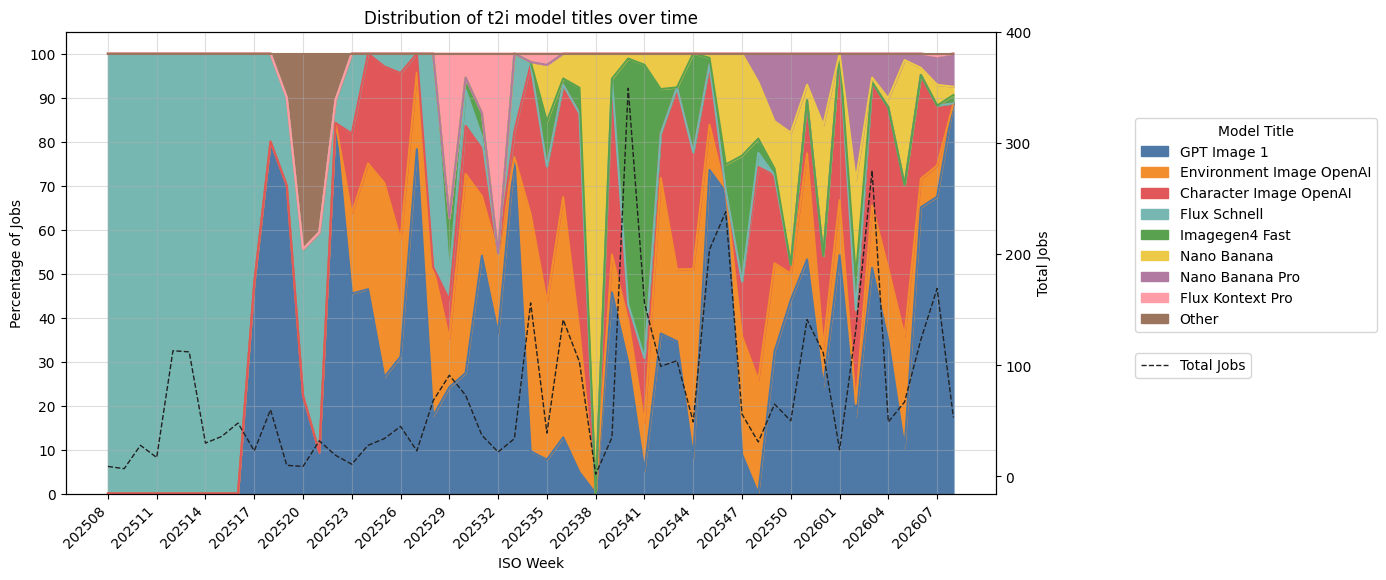

In [190]:
list_model_types = df['model_type'].value_counts().index.tolist() 
#for model_type in list_model_types:
for model_type in ['i2i','i2v','t2s','t2i']:
    # Let's make a cool visualization of the most common model titles for each model type per week
    #print(f"Model type: {model_type}")
    df_type_week = df[df['model_type'] == model_type].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
    # Let's make a smart agregation of the model titles to just show the main ones and group the rest into "other"
    top_n = 8
    top_titles = df_type_week.sum().nlargest(top_n).index
    df_type_week['Other'] = df_type_week.drop(columns=top_titles).sum(axis=1)
    df_type_week = df_type_week[top_titles.tolist() + ['Other']]
    # normalize by row  
    df_type_week_dist = 100*df_type_week.div(df_type_week.sum(axis=1), axis=0)
    round(df_type_week_dist.tail(),1)

    fig, ax = plt.subplots(figsize=(12, 6))

    # area chart (percent)
    df_type_week_dist.plot(kind='area', ax=ax, stacked=True, color=palette[:df_type_week_dist.shape[1]])
    ax.set_title(f'Distribution of {model_type} model titles over time')
    ax.set_xlabel('ISO Week')
    ax.set_ylabel('Percentage of Jobs')
    ax.set_yticks(range(0, 101, 10))
    ax.legend(title='Model Title', loc=(1.15, 0.35))
    ax.grid(alpha=0.4)


    step = 3  # 1=every week, 2=every 2 weeks, etc.
    x = np.arange(len(df_type_week_dist.index))

    ax.set_xticks(x[::step])
    ax.set_xticklabels(df_type_week_dist.index[::step].astype(str), rotation=45, ha="right")

    # secondary axis (absolute totals)
    ax2 = ax.twinx()
    total_cost = df_type_week.sum(axis=1)
    ax2.plot(total_cost.index, total_cost.values, color="#222222", linewidth=1.0, linestyle='--', label='Total Jobs')
    ax2.set_ylabel('Total Jobs')

    # 250-step ticks
    ymax = total_cost.max()
    ax2.set_yticks(range(0, int(ymax) + 100, 100))

    ax2.legend(loc=(1.15, 0.25))

    plt.show()


In [177]:
df_type_week = df[df['model_type'] == 'i2i'].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
# Let's make a smart agregation of the model titles to just show the main ones and group the rest into "other"
top_n = 8
top_titles = df_type_week.sum().nlargest(top_n).index
df_type_week['Other'] = df_type_week.drop(columns=top_titles).sum(axis=1)
df_type_week = df_type_week[top_titles.tolist() + ['Other']]
# normalize by row  
df_type_week_dist = 100*df_type_week.div(df_type_week.sum(axis=1), axis=0)
round(df_type_week_dist.tail(),1)

modelConfig.modelTitle,Shot Image OpenAI,Nano Banana,GPT Image 1,Fal Nano Banana Pro,Replicate Nano Banana Pro,Nano Banana Pro,Flux Kontext Pro,Image Edit OpenAI,Other
isoweek,,,,,,,,,
202604,0.0,9.6,0.1,70.1,19.4,0.0,0.7,0.0,0.0
202605,0.0,6.3,1.5,82.2,9.4,0.0,0.5,0.0,0.0
202606,0.0,2.8,3.1,85.4,8.2,0.0,0.4,0.0,0.1
202607,0.0,3.7,0.7,84.8,3.9,0.0,0.3,0.0,6.6
202608,0.0,1.3,0.7,45.4,0.0,0.0,0.0,0.0,52.6


In [181]:
#df_type_week = df[df['model_type'] == 'i2i'].groupby(['isoweek', 'modelConfig.modelTitle']).size().unstack().fillna(0)
#df_type_week

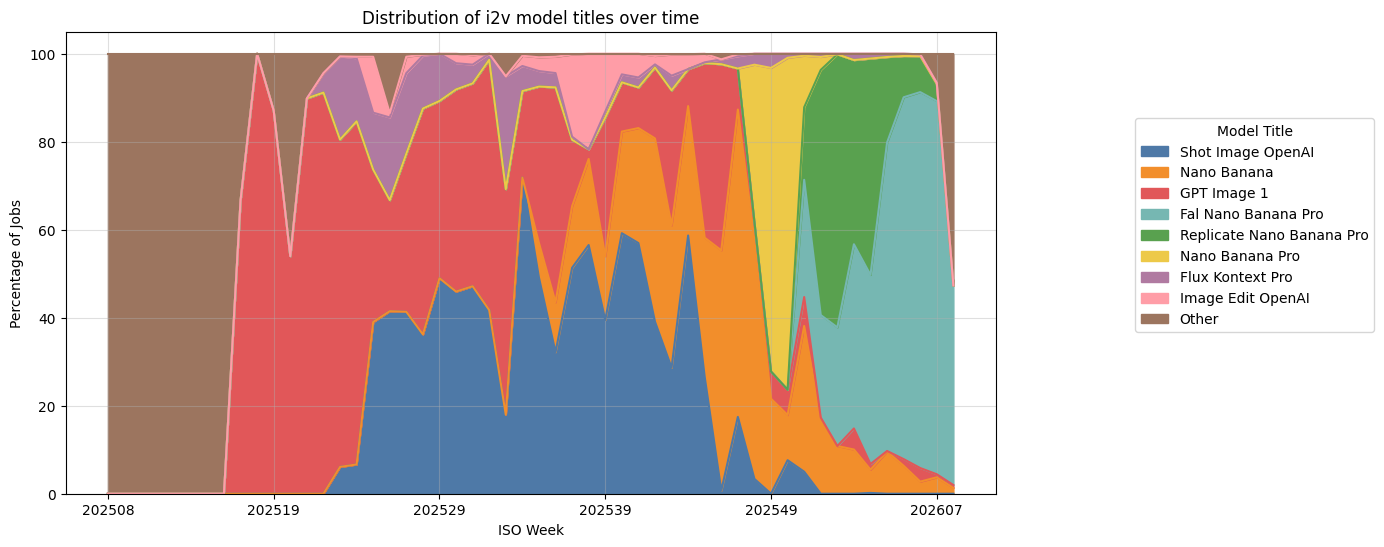

In [ ]:

df_type_week_dist.plot(kind='area', stacked=True, figsize=(12, 6), color=palette[:df_type_week_dist.shape[1]])
plt.title('Distribution of i2v model titles over time')
plt.xlabel('ISO Week')
plt.ylabel('Percentage of Jobs')
plt.legend(title='Model Title', loc=(1.15, 0.35))
plt.grid(alpha=0.4)
plt.show()

In [152]:
df.groupby('modelConfig.modelTitle').size().sort_values(ascending=False).head(10)

modelConfig.modelTitle
GPT Image 1                  5791
Nano Banana                  4864
Shot Image OpenAI            4742
Fal Nano Banana Pro          4106
Seedance 1 Pro               4038
Kling V2.5 Turbo Pro         2477
Replicate Nano Banana Pro    2172
Nano Banana Pro              1672
Hailuo 2.0                   1002
Flux Kontext Pro              796
dtype: int64

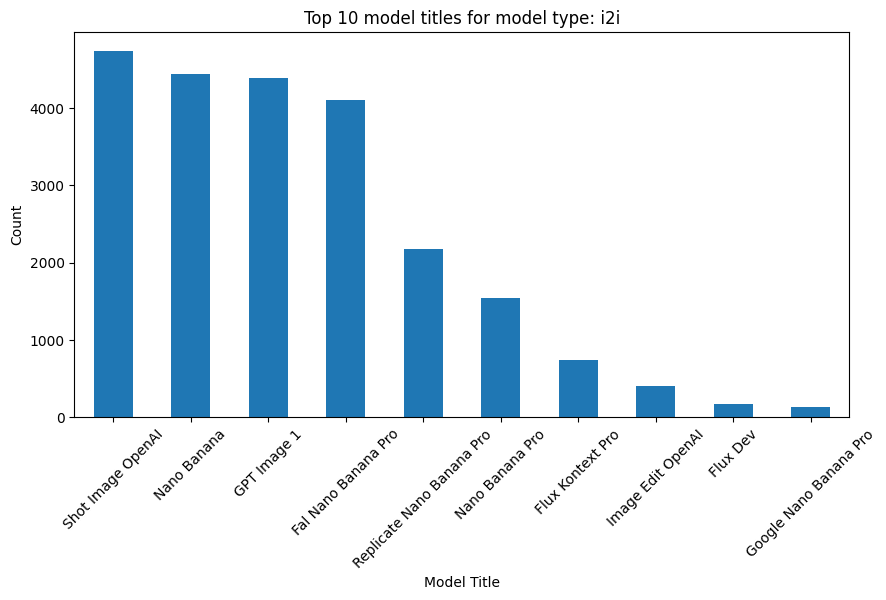

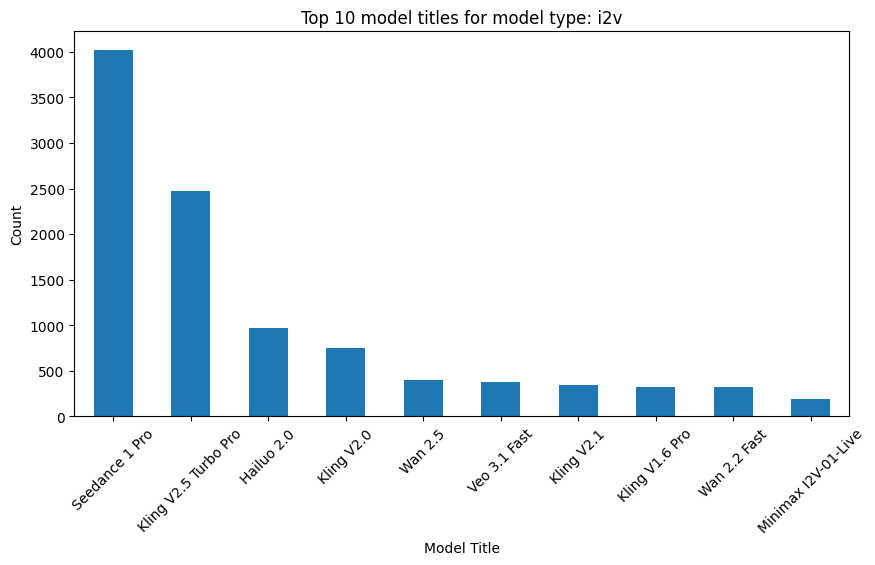

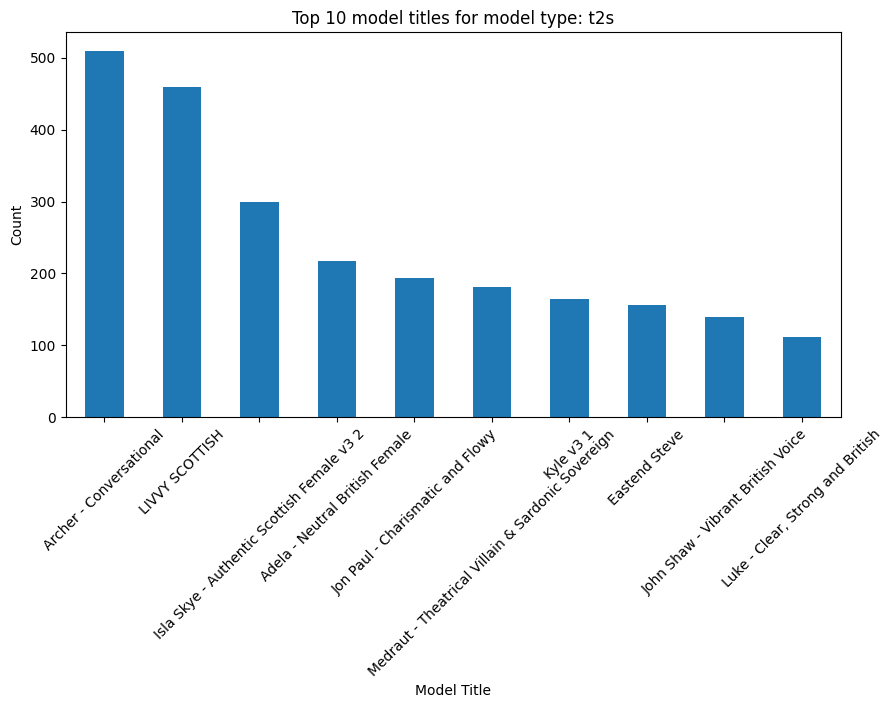

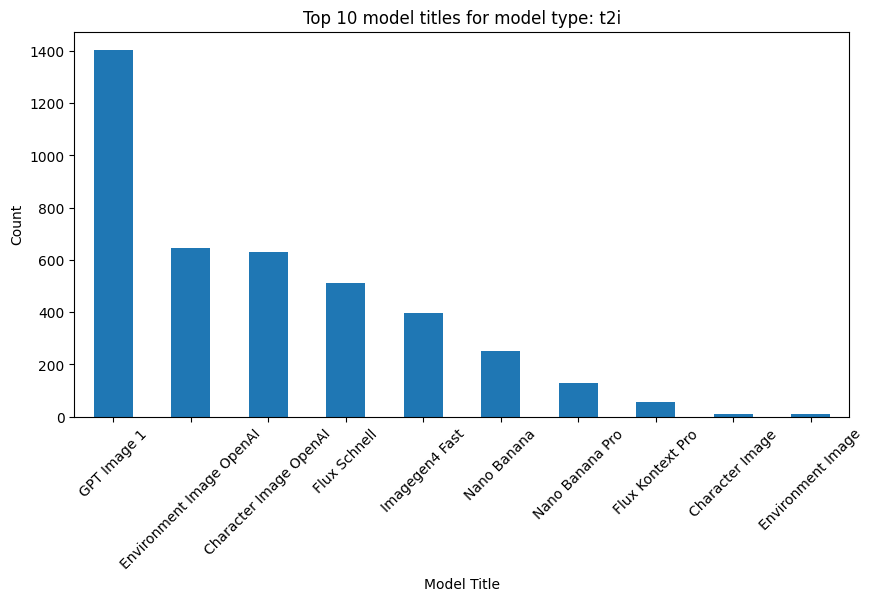

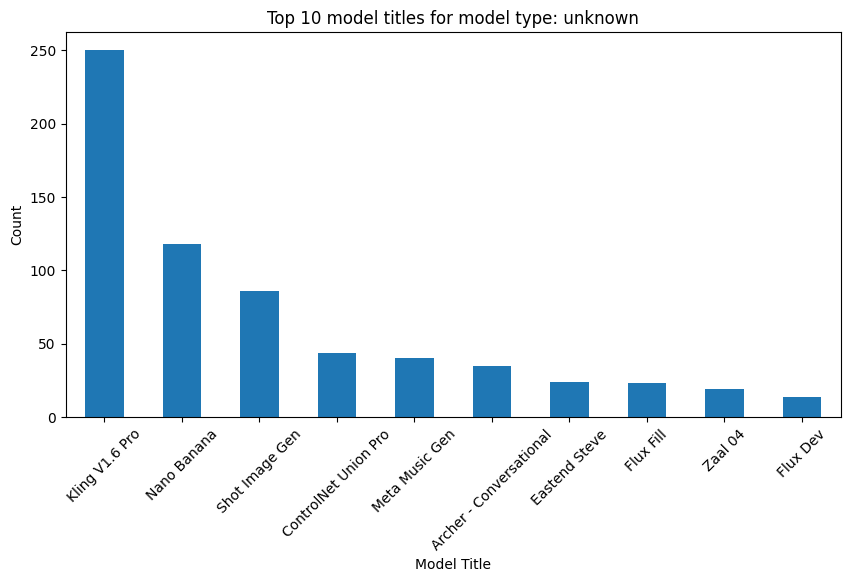

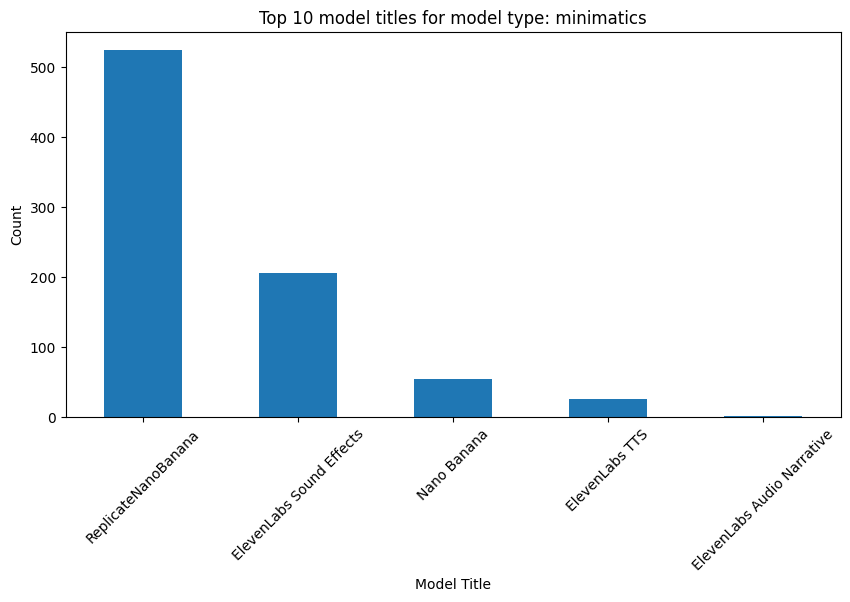

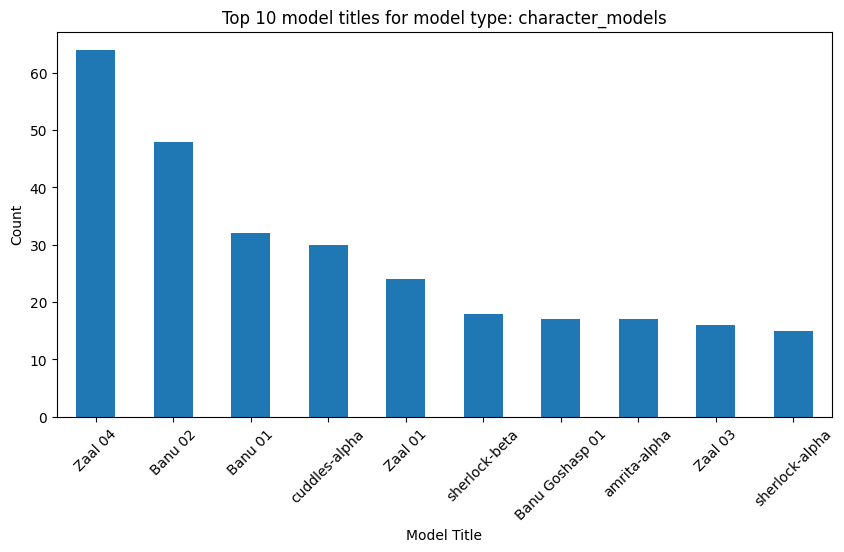

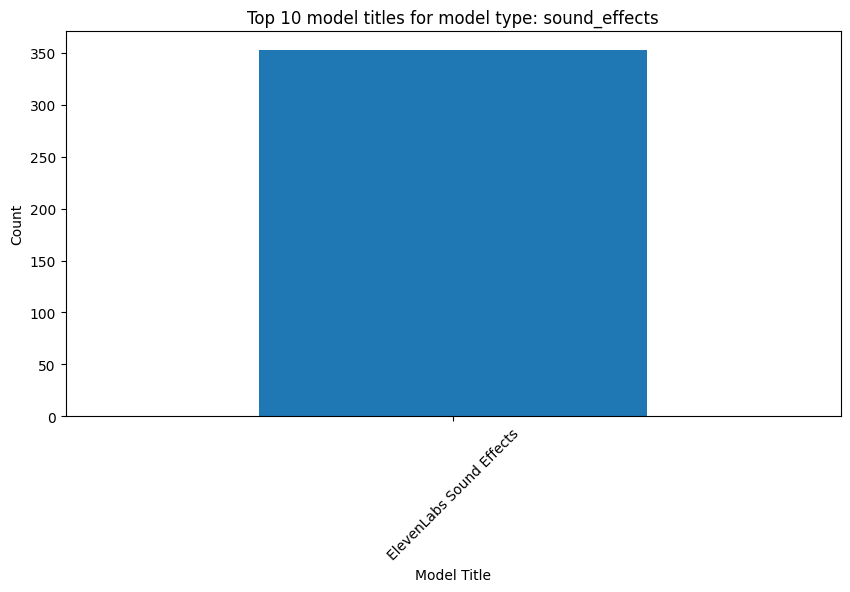

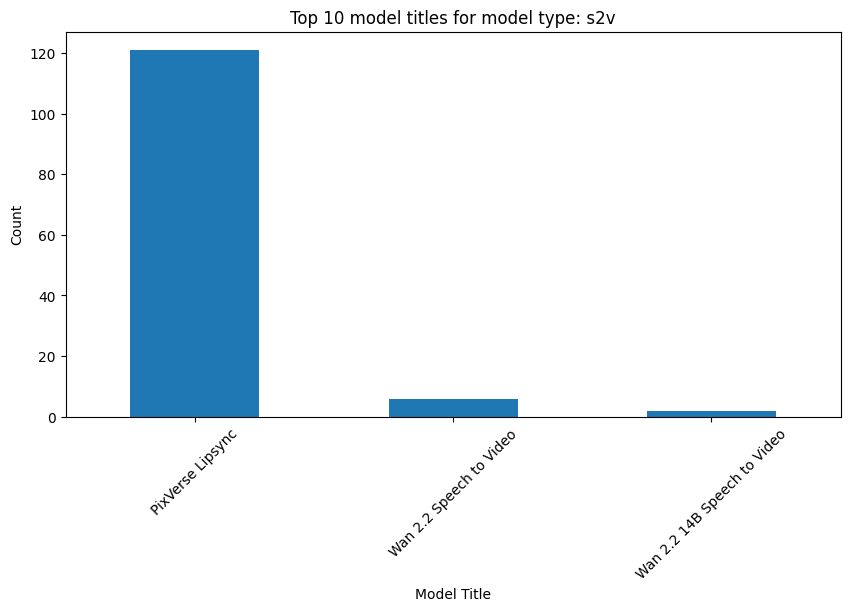

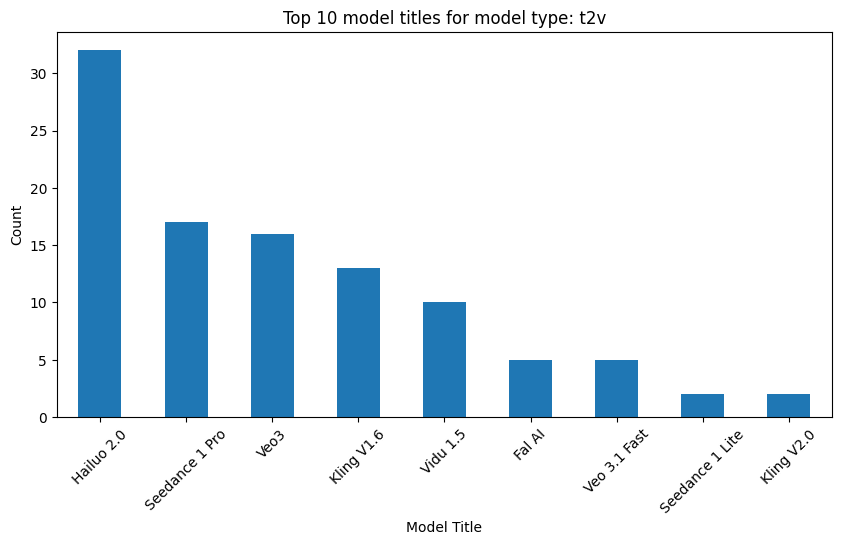

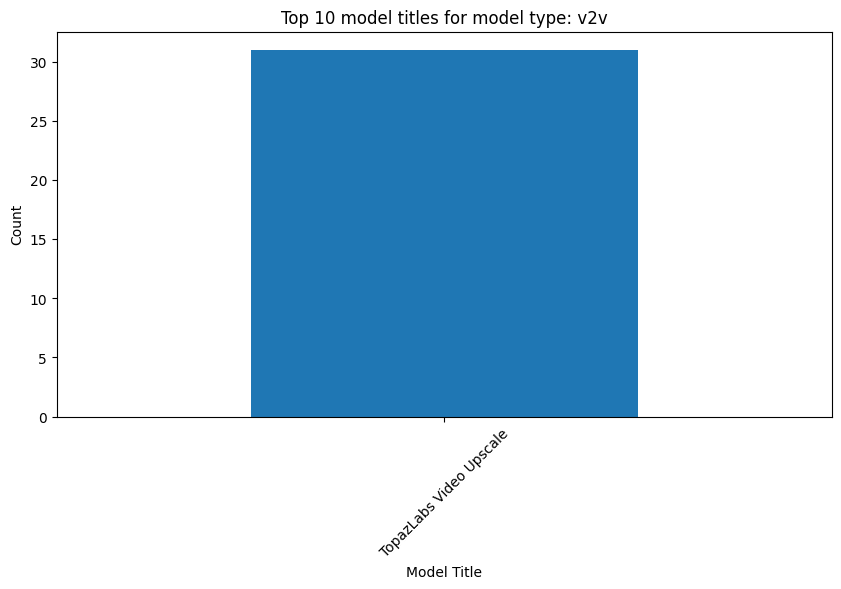

In [153]:
list_model_types = df['model_type'].value_counts().index.tolist() 
for model_type in list_model_types:
    # Let's make a cool visualization of the most common model titles for each model type
    #print(f"Model type: {model_type}")
    df_type = df[df['model_type'] == model_type]['modelConfig.modelTitle'].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    df_type.head(10).plot(kind='bar', ax=ax)
    ax.set_title(f"Top 10 model titles for model type: {model_type}")
    ax.set_xlabel("Model Title")
    ax.set_ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


In [154]:
df.sample(5)

,_id,jobId,userId,createdAt,status,updatedAt,modelConfig.name,modelConfig.id,modelConfig.outputType,modelConfig.modelType,modelConfig.provider,modelConfig.pollingIntervalMs,modelConfig.noOfGenerations,modelConfig.inputs,outputLinks.cancel,outputLinks.poll,outputLinks.stream,outputLinks.result,modelConfig.modelTitle,jobMetaData.traits,jobMetaData.artStyle,jobMetaData.characterName,error.code,error.message,error.details.timestamp,jobMetaData.controlNetConfigId,modelConfig.modelMetaData.replicatePredictionURL,jobMetaData.destinationModelName,error.details.modelId,modelMetaData.traits,modelMetaData.artStyle,modelMetaData.characterName,assetId,modelConfig.modelMetaData.waitForCompletion,jobFeedback.isLiked,jobMetaData.triggerWord,jobMetaData.b2ZipUrl,modelConfig.modelMetaData.viduPredictionURL,jobMetaData.jobBatchId,modelConfig.modelLabels,modelConfig.costConfig.defaultCost,modelConfig.costConfig.rules,outputLinks.result.version,outputLinks.result.weights,jobMetaData.gender,modelConfig.modelMetaData.elevenLabsVoiceId,logs,qualityAnalysis.score,qualityAnalysis.reasoning,qualityAnalysis.transformedScore,qualityAnalysis.actionableFeedback,sharedWith,userEmail,jobSharingUsersList,jobSharingUsers,modelConfig.hasLora,modelConfig.modelMetaData.openAIModelId,jobMetaData,qualityAnalysis.humanScore,modelConfig.modelMetaData.useWebhook,serviceId,qualityAnalysis.emoji,qualityAnalysis.rewrittenPrompt,modelConfig.modelMetaData.xAIModelId,modelConfig.modelMetaData.grokAIModelId,modelConfig.modelMetaData.falAIModelId,error.details.serviceId,error.details.requestId,qualityAnalysis.qualityCheckStatus,subJobs,jobMetaData.jobIndex,jobMetaData.useWebhook,jobMetaData.useWebSocket,jobMetaData.socketId,jobMetaData.requestId,storyLinks.storyId,storyLinks.sceneId,storyLinks.shotId,error.details.stack,jobMetaData.promptLineage.originalJobId,jobMetaData.promptLineage.rewrittenPrompt,minimaticsLinks.projectId,minimaticsLinks.characterId,jobMetaData.projectId,jobMetaData.shotId,resultDownloadedAt,minimaticsLinks.shotId,projectLinks.projectId,projectLinks.environmentId,projectLinks.characterId,modelConfig.modelMetaData.maxNumberOfReferences,projectLinks,testMode,jobMetaData.storyId,jobMetaData.sceneId,jobMetaData.isSketchToShotImage,jobMetaData.reasoningEffort,jobMetaData.isAssetImageGeneration,jobMetaData.assetType,jobMetaData.assetTitle,jobMetaData.assetDescription,jobMetaData.artStyleText,jobMetaData.artStyleImages,jobMetaData.existingCharacters,jobMetaData.existingEnvironments,jobMetaData.preparedPrompt,jobMetaData.preparedReferences,jobMetaData.promptReasoning,modelConfig.modelMetaData.googleGeminiModelId,dt,isoyear,isoweek,model_type,model_type_agg
36155,6954eea579df01c2309c2c53,b0bcbb0a-2d8d-43a9-be07-428ee64e56ae,3e1f37e7-c1df-45c4-ace4-239a303e5bd6,2025-12-31 09:36:37.612,completed,2025-12-31 09:37:51.912,Image to Image,i2i-nanoBananaPro,IMAGE,IMAGE_GEN,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': 'TEXT', 'isRequired': True, 'value': 'remove the background , and make it white'}, {'id': 'image_input', 'label': 'Input Image', 'type': 'MULTIPLE_IMAGE', 'isRequired': True, 'maxInputLength': 14, 'value': ['https://renderboard-test.s3.us-east-005.backblazeb2.com/images/asset-6c328d21-1614-44ce-a9d5-9766da77f492']}, {'id': 'aspect_ratio', 'label': 'Aspect Ratio', 'type': 'SELECT', 'isRequired': True, 'defaultValue': '16:9', 'value': '16:9', 'selectOptions': [{'label': '1:1', 'value': '1:1'}, {'label': '2:3', 'value': '2:3'}, {'label': '3:2', 'value': '3:2'}, {'label': '3:4', 'value': '3:4'}, {'label': '4:3', 'value': '4:3'}, {'label': '4:5', 'value': '4:5'}, {'label': '5:4', 'value': '5:4'}, {'label': '9:16', 'value': '9:16'}, {'label': '16:9', 'value': '16:9'}, {'label': '21:9', 'value': '21:9'}]}, {'id': 'resolution', 'label': 'Resolution', 'type': 'SELECT', 'isRequired': False, 'defaultValue': '1K', 'value': '2K', 'selectOptions': [{'label': '1K', 'value': '1K'}, {'label': '2K', 'value': '2K'}]}, {'id': 'output_format', 'label': 'Output 

In [155]:
df[['_id','modelConfig.id','modelConfig.costConfig.defaultCost']].groupby('modelConfig.id').agg({'modelConfig.costConfig.defaultCost': 'mean'}).sort_values(by='modelConfig.costConfig.defaultCost', ascending=False).head(10)

,modelConfig.costConfig.defaultCost
modelConfig.id,
t2vVeo3,6.00
i2vVeo2,2.50
i2vKling2,1.40
t2vKling2,1.40
i2vKling3Pro,1.12
i2vVeo3p1Fast,0.90
t2vVeo3p1Fast,0.90
i2vKling3Standard,0.84
i2vSeedancePro,0.75


In [156]:
df['modelConfig.costConfig.defaultCost'].value_counts().head(10)

modelConfig.costConfig.defaultCost
0.180    9817
0.039    4692
0.150    4172
0.750    4038
0.140    3841
0.420    2477
0.020    1750
0.270    1012
0.040     832
1.400     754
Name: count, dtype: int64

In [157]:
list_columns = list(df.columns)
for col in list_columns:
    print(col)

_id
jobId
userId
createdAt
status
updatedAt
modelConfig.name
modelConfig.id
modelConfig.outputType
modelConfig.modelType
modelConfig.provider
modelConfig.pollingIntervalMs
modelConfig.noOfGenerations
modelConfig.inputs
outputLinks.cancel
outputLinks.poll
outputLinks.stream
outputLinks.result
modelConfig.modelTitle
jobMetaData.traits
jobMetaData.artStyle
jobMetaData.characterName
error.code
error.message
error.details.timestamp
jobMetaData.controlNetConfigId
modelConfig.modelMetaData.replicatePredictionURL
jobMetaData.destinationModelName
error.details.modelId
modelMetaData.traits
modelMetaData.artStyle
modelMetaData.characterName
assetId
modelConfig.modelMetaData.waitForCompletion
jobFeedback.isLiked
jobMetaData.triggerWord
jobMetaData.b2ZipUrl
modelConfig.modelMetaData.viduPredictionURL
jobMetaData.jobBatchId
modelConfig.modelLabels
modelConfig.costConfig.defaultCost
modelConfig.costConfig.rules
outputLinks.result.version
outputLinks.result.weights
jobMetaData.gender
modelConfig.model

In [158]:
# qualityAnalysis.qualityCheckStatus
# jobFeedback.isLiked
#modelConfig.costConfig.defaultCost
#modelConfig.costConfig.rules
# outputLinks.result.weights
# qualityAnalysis.score
# qualityAnalysis.reasoning
# qualityAnalysis.transformedScore
# qualityAnalysis.actionableFeedback
# qualityAnalysis.humanScore
# qualityAnalysis.emoji
# qualityAnalysis.rewrittenPrompt
# qualityAnalysis.qualityCheckStatus
df[['qualityAnalysis.qualityCheckStatus',
    'jobFeedback.isLiked',
    'modelConfig.costConfig.defaultCost',
    'modelConfig.costConfig.rules',
    'outputLinks.result.weights',
    'qualityAnalysis.score',
    'qualityAnalysis.reasoning',
    'qualityAnalysis.transformedScore',
    'qualityAnalysis.actionableFeedback',
    'qualityAnalysis.humanScore',
    'qualityAnalysis.emoji',
    'qualityAnalysis.rewrittenPrompt',
    'qualityAnalysis.qualityCheckStatus']].sample(10)

,qualityAnalysis.qualityCheckStatus,jobFeedback.isLiked,modelConfig.costConfig.defaultCost,modelConfig.costConfig.rules,outputLinks.result.weights,qualityAnalysis.score,qualityAnalysis.reasoning,qualityAnalysis.transformedScore,qualityAnalysis.actionableFeedback,qualityAnalysis.humanScore,qualityAnalysis.emoji,qualityAnalysis.rewrittenPrompt,qualityAnalysis.qualityCheckStatus
17736,completed,NaN,0.039,NaN,NaN,5.0,"The generated image does not fulfill the prompt requirement—there are still only two window panels in the boat's cabin, not three as specified. The character is consistent in facial features, pose, and appearance between the images, and there are no significant visual artifacts, but the central requirement of having three window panels is not met.",2,"Setting - The generated image does not meet the main prompt requirement of having three window panels in the boat's cabin, which is a key element for positioning the character correctly.",NaN,NaN,"Modify the boat cabin so that the front window consists of three vertical panels instead of two, with the person positioned at the center window panel, steering the wheel. Maintain the nighttime setting, warm lantern light, and overall mood of the original image.",completed
12324,completed,NaN,0.180,NaN,NaN,10.0,"The generated image perfectly fulfills the prompt by showing only the wall with the frames on it, with no chairs or table present. The salient elements from the prompt (the wall and framed pictures) are accurately recreated, and there are no visible visual artifacts or distortions.",4,,NaN,NaN,NaN,completed
45373,completed,NaN,0.150,NaN,NaN,9.0,"Nearly perfect Berserk-style conversion with strong adherence to prompt: pure black-and-white, no gradients, heavy chiaroscuro, deep ink shadows, and dense hatch detailing. Hair is solid black with white streaks, armor has engrave-style hatch, and the impact is a bold, white burst with aggressive impact lines and shard debris. The oppressive, violent seinen atmosphere and stormy hatch background are present. However, there is a hint of digital smoothness/blur behind the character’s head (top right), and some background storm/wind areas appear less heavily inked/hatched than expected in traditional Berserk panels. Character identity, pose, armor, and expression are consistent with the prompt’s description and implied reference, with no anatomical distortions or major flaws. Minor digital blending in the vignette prevents a perfect 10.",4,"Style - Minor digital smoothness/blur is visible behind the character’s head (top right) and some background storm/wind areas are less heavily inked/hatched than expected in traditional Berserk panels. This slightly reduces the intensity of the oppressive, hand-drawn effect. Background - Digital blending in the vignette reduces the authentic manga ink texture.",NaN,NaN,NaN,completed
16666,failed,NaN,0.180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,failed
17637,failed,NaN,0.180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,failed
19805,completed,NaN,0.750,"[{'conditions': [{'inputId': 'resolution', 'value': '480p'}, {'inputId': 'duration', 'value': 5}], 'cost': 0.15}, {'conditions': [{'inputId': 'resolution', 'value': '480p'}, {'inputId': 'duration', 'value': 10}], 'cost': 0.3}, {'conditions': [{'inputId': 'resolution', 'value': '1080p'}, {'inputId': 'duration', 'value': 5}], 'cost': 0.75}, {'conditions': [{'inputId': 'resolution', 'value': '1080p'}, {'inputId': 'duration', 'value': 10}], 'cost': 1.5}]",NaN,8.0,"There is strong character consistency and the overall sequence accurately follows the prompt, depicting the panic, stumbling, and clutching of the forearm with naturalistic expressions, cinematic dread, and handheld camera movement. However, notable video artifacts become apparent: as the boy transitions from reaching out to falling, there are unrealistic distortions in the hands, occasional oddness in the eyes, and visible red splotches/hallucinations on the cheeks and eyes in later frames, breaking re

In [159]:
#df['qualityAnalysis.reasoning'].value_counts().head(20)

In [160]:
# Display all text in a cell without truncation
pd.set_option('display.max_colwidth', None)
df[['modelConfig.costConfig.rules']].loc[3344]

modelConfig.costConfig.rules    [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
Name: 3344, dtype: object

In [161]:
# modelConfig.costConfig.defaultCost --> Cost of the job  
# modelConfig.costConfig.rules	--> Not sure, but seems to be a JSON with the cost breakdown of the job (e.g. compute time, storage, etc.) [{'conditions': [{'inputId': 'duration', 'value': '5'}], 'cost': 1.4}, {'conditions': [{'inputId': 'duration', 'value': '10'}], 'cost': 2.8}]
# qualityAnalysis.score	--> Overall quality score (0-10)
# qualityAnalysis.reasoning --> Explanation of the quality score (25000+ unique values, very long text in some cases). Is it LLM-generated? Seems to be, as some entries are very similar except for the numbers (e.g. "The quality score is 7 because the generated image has good composition and color balance, but the details are somewhat lacking." vs "The quality score is 3 because the generated video has poor resolution and noticeable artifacts throughout.")
# qualityAnalysis.transformedScore	--> Unclear but transformation of the original scoring
# qualityAnalysis.rewrittenPrompt	--> Rewritten prompt to improve quality 


In [162]:
'jobMetaData.storyId',
'jobMetaData.sceneId',
'jobMetaData.isSketchToShotImage',
'jobMetaData.reasoningEffort',
'jobMetaData.isAssetImageGeneration',
'jobMetaData.assetType',
'jobMetaData.assetTitle',
'jobMetaData.assetDescription',
'jobMetaData.artStyleText',
'jobMetaData.artStyleImages',
'jobMetaData.existingCharacters',
'jobMetaData.existingEnvironments',
'jobMetaData.preparedPrompt',
'jobMetaData.preparedReferences',
'jobMetaData.promptReasoning']

SyntaxError: unmatched ']' (3315141502.py, line 15)

In [ ]:
100*df['model_type'].value_counts(normalize=True)

model_type
i2i                 50.310805
i2v                 23.502537
t2s                 11.443759
t2i                  8.856283
unknown              1.906561
minimatics           1.781361
character_models     0.845652
sound_effects        0.775364
s2v                  0.283348
t2v                  0.226239
v2v                  0.068091
Name: proportion, dtype: float64

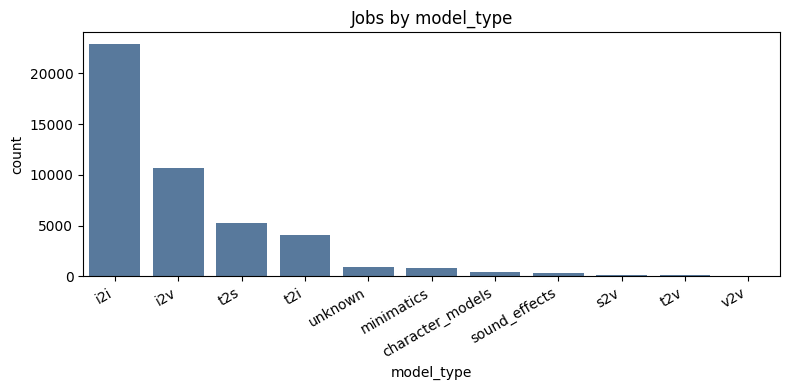

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of counts by model_type
counts = df['model_type'].fillna('unknown').value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=counts.index, y=counts.values, color="#4C78A8")
ax.set_title("Jobs by model_type")
ax.set_xlabel("model_type")
ax.set_ylabel("count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()


Variables that feel to some extent important


- resultDownloadedAt --> good proxy to capture if they output was good

In [ ]:
df[df['model_type'] == 'unknown']['modelConfig.id'].value_counts().head(20)

modelConfig.id
fluxKontextPro           807
google/nano-banana       708
soundEffectElevenLabs    559
Fahco4VZzobUeiPqni1S     545
fluxschnell              523
mmC3q9a9xRiR1m1UBHbj     460
imagegen4fast            394
ptBd2v6mebIps3ZQEXD7     312
jXuksIgonIKWaPC8gdwP     299
startEndToVideoKling     250
rdDUoCO1RjwdMmNjmhHV     225
dG7SBJDxDoZkQUrwvqrD     181
1TE7ou3jyxHsyRehUuMB     180
7Ren0A2JmdY0SeJTRLy4     177
fluxDev                  172
pUc0ICJmfLt4tXNq3KNb     139
s2vPixverseLipsync       121
aAbVdJPWb3aJZA1ax31H     110
b6UtgdzviyF3kdUzNIlT      97
exsUS4vynmxd379XN4yO      96
Name: count, dtype: int64

In [ ]:
df.head()

,_id,jobId,userId,createdAt,status,updatedAt,modelConfig.name,modelConfig.id,modelConfig.outputType,modelConfig.modelType,modelConfig.provider,modelConfig.pollingIntervalMs,modelConfig.noOfGenerations,modelConfig.inputs,outputLinks.cancel,outputLinks.poll,outputLinks.stream,outputLinks.result,modelConfig.modelTitle,jobMetaData.traits,jobMetaData.artStyle,jobMetaData.characterName,error.code,error.message,error.details.timestamp,jobMetaData.controlNetConfigId,modelConfig.modelMetaData.replicatePredictionURL,jobMetaData.destinationModelName,error.details.modelId,modelMetaData.traits,modelMetaData.artStyle,modelMetaData.characterName,assetId,modelConfig.modelMetaData.waitForCompletion,jobFeedback.isLiked,jobMetaData.triggerWord,jobMetaData.b2ZipUrl,modelConfig.modelMetaData.viduPredictionURL,jobMetaData.jobBatchId,modelConfig.modelLabels,modelConfig.costConfig.defaultCost,modelConfig.costConfig.rules,outputLinks.result.version,outputLinks.result.weights,jobMetaData.gender,modelConfig.modelMetaData.elevenLabsVoiceId,logs,qualityAnalysis.score,qualityAnalysis.reasoning,qualityAnalysis.transformedScore,qualityAnalysis.actionableFeedback,sharedWith,userEmail,jobSharingUsersList,jobSharingUsers,modelConfig.hasLora,modelConfig.modelMetaData.openAIModelId,jobMetaData,qualityAnalysis.humanScore,modelConfig.modelMetaData.useWebhook,serviceId,qualityAnalysis.emoji,qualityAnalysis.rewrittenPrompt,modelConfig.modelMetaData.xAIModelId,modelConfig.modelMetaData.grokAIModelId,modelConfig.modelMetaData.falAIModelId,error.details.serviceId,error.details.requestId,qualityAnalysis.qualityCheckStatus,subJobs,jobMetaData.jobIndex,jobMetaData.useWebhook,jobMetaData.useWebSocket,jobMetaData.socketId,jobMetaData.requestId,storyLinks.storyId,storyLinks.sceneId,storyLinks.shotId,error.details.stack,jobMetaData.promptLineage.originalJobId,jobMetaData.promptLineage.rewrittenPrompt,minimaticsLinks.projectId,minimaticsLinks.characterId,jobMetaData.projectId,jobMetaData.shotId,resultDownloadedAt,minimaticsLinks.shotId,projectLinks.projectId,projectLinks.environmentId,projectLinks.characterId,modelConfig.modelMetaData.maxNumberOfReferences,projectLinks,testMode,jobMetaData.storyId,jobMetaData.sceneId,jobMetaData.isSketchToShotImage,jobMetaData.reasoningEffort,jobMetaData.isAssetImageGeneration,jobMetaData.assetType,jobMetaData.assetTitle,jobMetaData.assetDescription,jobMetaData.artStyleText,jobMetaData.artStyleImages,jobMetaData.existingCharacters,jobMetaData.existingEnvironments,jobMetaData.preparedPrompt,jobMetaData.preparedReferences,jobMetaData.promptReasoning,modelConfig.modelMetaData.googleGeminiModelId,model_type
0,67a49e93b2506bebffb39f01,84590c78-181b-4c75-aaa2-637b11f7f623,76de864a-c6da-4189-bcb0-2dc5e4dc08e0,2025-02-06 11:35:45.368,completed,2025-02-06 11:37:28.469,Character Generation,lucataco/controlnet-union-pro:bd0dacc60e6247a2...,CONTROL_NET,CONTROL_NET,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': '...",https://api.replicate.com/v1/predictions/243j5...,https://api.replicate.com/v1/predictions/243j5...,https://stream.replicate.com/v1/files/bcwr-m6m...,https://renderboard-test.s3.us-east-005.backbl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
1,67ac3503f9173eb4750d1792,f221bb6b-9dea-4915-901d-72a6f86ae6d1,76de864a-c6da-4189-bcb0-2dc5e4dc08e0,2025-02-12 05:43:30.148,completed,2025-02-12 05:44:44.954,Character Generation,lucataco/controlnet-union-pro:bd0dacc60e6247a2...,CONTROL_NET,CONTROL_NET,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': '...",https://api.replicate.com/v1/predictions/qx6cn...,https://api.replicate.com/v1/predictions/qx6cn...,https://stream.replicate.com/v1/files/bcwr-y3

In [ ]:
df[df['model_type'] == 'unknown']

,_id,jobId,userId,createdAt,status,updatedAt,modelConfig.name,modelConfig.id,modelConfig.outputType,modelConfig.modelType,modelConfig.provider,modelConfig.pollingIntervalMs,modelConfig.noOfGenerations,modelConfig.inputs,outputLinks.cancel,outputLinks.poll,outputLinks.stream,outputLinks.result,modelConfig.modelTitle,jobMetaData.traits,jobMetaData.artStyle,jobMetaData.characterName,error.code,error.message,error.details.timestamp,jobMetaData.controlNetConfigId,modelConfig.modelMetaData.replicatePredictionURL,jobMetaData.destinationModelName,error.details.modelId,modelMetaData.traits,modelMetaData.artStyle,modelMetaData.characterName,assetId,modelConfig.modelMetaData.waitForCompletion,jobFeedback.isLiked,jobMetaData.triggerWord,jobMetaData.b2ZipUrl,modelConfig.modelMetaData.viduPredictionURL,jobMetaData.jobBatchId,modelConfig.modelLabels,modelConfig.costConfig.defaultCost,modelConfig.costConfig.rules,outputLinks.result.version,outputLinks.result.weights,jobMetaData.gender,modelConfig.modelMetaData.elevenLabsVoiceId,logs,qualityAnalysis.score,qualityAnalysis.reasoning,qualityAnalysis.transformedScore,qualityAnalysis.actionableFeedback,sharedWith,userEmail,jobSharingUsersList,jobSharingUsers,modelConfig.hasLora,modelConfig.modelMetaData.openAIModelId,jobMetaData,qualityAnalysis.humanScore,modelConfig.modelMetaData.useWebhook,serviceId,qualityAnalysis.emoji,qualityAnalysis.rewrittenPrompt,modelConfig.modelMetaData.xAIModelId,modelConfig.modelMetaData.grokAIModelId,modelConfig.modelMetaData.falAIModelId,error.details.serviceId,error.details.requestId,qualityAnalysis.qualityCheckStatus,subJobs,jobMetaData.jobIndex,jobMetaData.useWebhook,jobMetaData.useWebSocket,jobMetaData.socketId,jobMetaData.requestId,storyLinks.storyId,storyLinks.sceneId,storyLinks.shotId,error.details.stack,jobMetaData.promptLineage.originalJobId,jobMetaData.promptLineage.rewrittenPrompt,minimaticsLinks.projectId,minimaticsLinks.characterId,jobMetaData.projectId,jobMetaData.shotId,resultDownloadedAt,minimaticsLinks.shotId,projectLinks.projectId,projectLinks.environmentId,projectLinks.characterId,modelConfig.modelMetaData.maxNumberOfReferences,projectLinks,testMode,jobMetaData.storyId,jobMetaData.sceneId,jobMetaData.isSketchToShotImage,jobMetaData.reasoningEffort,jobMetaData.isAssetImageGeneration,jobMetaData.assetType,jobMetaData.assetTitle,jobMetaData.assetDescription,jobMetaData.artStyleText,jobMetaData.artStyleImages,jobMetaData.existingCharacters,jobMetaData.existingEnvironments,jobMetaData.preparedPrompt,jobMetaData.preparedReferences,jobMetaData.promptReasoning,modelConfig.modelMetaData.googleGeminiModelId,model_type
0,67a49e93b2506bebffb39f01,84590c78-181b-4c75-aaa2-637b11f7f623,76de864a-c6da-4189-bcb0-2dc5e4dc08e0,2025-02-06 11:35:45.368,completed,2025-02-06 11:37:28.469,Character Generation,lucataco/controlnet-union-pro:bd0dacc60e6247a2...,CONTROL_NET,CONTROL_NET,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': '...",https://api.replicate.com/v1/predictions/243j5...,https://api.replicate.com/v1/predictions/243j5...,https://stream.replicate.com/v1/files/bcwr-m6m...,https://renderboard-test.s3.us-east-005.backbl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
1,67ac3503f9173eb4750d1792,f221bb6b-9dea-4915-901d-72a6f86ae6d1,76de864a-c6da-4189-bcb0-2dc5e4dc08e0,2025-02-12 05:43:30.148,completed,2025-02-12 05:44:44.954,Character Generation,lucataco/controlnet-union-pro:bd0dacc60e6247a2...,CONTROL_NET,CONTROL_NET,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': '...",https://api.replicate.com/v1/predictions/qx6cn...,https://api.replicate.com/v1/predictions/qx6cn...,https://stream.replicate.com/v1/files/bcwr-y3

In [ ]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120
df.sample(3).T

,37381,43638,8538
_id,6964900c79df01c2309e51c8,698af9a7785a26f04de34a9b,687570afeebfe6ba351a0a2a
jobId,e3192972-775c-4272-97a1-b7d1bd4db476,9f2a7094-3a02-4b50-a540-c72995b13b94,1da72acd-6826-4888-9b32-a4bcd1736cd9
userId,bec7368e-845a-4075-acbb-557249937bb5,62e16e77-b880-4b2e-a06b-1b19c8db6156,de4b6003-2c85-49d0-bde5-b3b28dd9c1f4
createdAt,2026-01-12 06:09:16.720000,2026-02-10 09:25:58.985000,2025-07-14 21:03:43.815000
status,completed,completed,completed
updatedAt,2026-01-12 06:12:01.696000,2026-02-10 09:27:37.605000,2025-07-14 21:03:43.815000
modelConfig.name,Image to Image,Image to Video,Sound Effects
modelConfig.id,i2i-nanoBananaPro,i2vSeedancePro,soundEffectElevenLabs
modelConfig.outputType,IMAGE,VIDEO,AUDIO
modelConfig.modelType,IMAGE_GEN,ASSET_GEN,SOUND_EFFECT


resultDownloadedAt	

In [ ]:
# query = {}
# model_ids=["I2V", "T2V"]
# query["modelConfig.id"] = {"$in": model_ids}

In [ ]:
# BASE_PROJECTION = {
#     "_id": 1,
#     "jobId": 1,
#     "createdAt": 1,
#     "updatedAt": 1,
#     "status": 1,
#     "userId": 1,
#     "modelConfig.id": 1,
#     "modelConfig.name": 1,
#     "modelConfig.provider": 1,
#     "error.code": 1,
#     "error.message": 1,
# }


In [ ]:
# df = pd.json_normalize(COLLECTION.find(
#         query,
#         BASE_PROJECTION
#     ))

In [ ]:
df.head()

,_id,jobId,userId,createdAt,status,updatedAt,modelConfig.name,modelConfig.id,modelConfig.outputType,modelConfig.modelType,modelConfig.provider,modelConfig.pollingIntervalMs,modelConfig.noOfGenerations,modelConfig.inputs,outputLinks.cancel,outputLinks.poll,outputLinks.stream,outputLinks.result,modelConfig.modelTitle,jobMetaData.traits,jobMetaData.artStyle,jobMetaData.characterName,error.code,error.message,error.details.timestamp,jobMetaData.controlNetConfigId,modelConfig.modelMetaData.replicatePredictionURL,jobMetaData.destinationModelName,error.details.modelId,modelMetaData.traits,modelMetaData.artStyle,modelMetaData.characterName,assetId,modelConfig.modelMetaData.waitForCompletion,jobFeedback.isLiked,jobMetaData.triggerWord,jobMetaData.b2ZipUrl,modelConfig.modelMetaData.viduPredictionURL,jobMetaData.jobBatchId,modelConfig.modelLabels,modelConfig.costConfig.defaultCost,modelConfig.costConfig.rules,outputLinks.result.version,outputLinks.result.weights,jobMetaData.gender,modelConfig.modelMetaData.elevenLabsVoiceId,logs,qualityAnalysis.score,qualityAnalysis.reasoning,qualityAnalysis.transformedScore,qualityAnalysis.actionableFeedback,sharedWith,userEmail,jobSharingUsersList,jobSharingUsers,modelConfig.hasLora,modelConfig.modelMetaData.openAIModelId,jobMetaData,qualityAnalysis.humanScore,modelConfig.modelMetaData.useWebhook,serviceId,qualityAnalysis.emoji,qualityAnalysis.rewrittenPrompt,modelConfig.modelMetaData.xAIModelId,modelConfig.modelMetaData.grokAIModelId,modelConfig.modelMetaData.falAIModelId,error.details.serviceId,error.details.requestId,qualityAnalysis.qualityCheckStatus,subJobs,jobMetaData.jobIndex,jobMetaData.useWebhook,jobMetaData.useWebSocket,jobMetaData.socketId,jobMetaData.requestId,storyLinks.storyId,storyLinks.sceneId,storyLinks.shotId,error.details.stack,jobMetaData.promptLineage.originalJobId,jobMetaData.promptLineage.rewrittenPrompt,minimaticsLinks.projectId,minimaticsLinks.characterId,jobMetaData.projectId,jobMetaData.shotId,resultDownloadedAt,minimaticsLinks.shotId,projectLinks.projectId,projectLinks.environmentId,projectLinks.characterId,modelConfig.modelMetaData.maxNumberOfReferences,projectLinks,testMode,jobMetaData.storyId,jobMetaData.sceneId,jobMetaData.isSketchToShotImage,jobMetaData.reasoningEffort,jobMetaData.isAssetImageGeneration,jobMetaData.assetType,jobMetaData.assetTitle,jobMetaData.assetDescription,jobMetaData.artStyleText,jobMetaData.artStyleImages,jobMetaData.existingCharacters,jobMetaData.existingEnvironments,jobMetaData.preparedPrompt,jobMetaData.preparedReferences,jobMetaData.promptReasoning,modelConfig.modelMetaData.googleGeminiModelId,model_type
0,67a49e93b2506bebffb39f01,84590c78-181b-4c75-aaa2-637b11f7f623,76de864a-c6da-4189-bcb0-2dc5e4dc08e0,2025-02-06 11:35:45.368,completed,2025-02-06 11:37:28.469,Character Generation,lucataco/controlnet-union-pro:bd0dacc60e6247a2...,CONTROL_NET,CONTROL_NET,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': '...",https://api.replicate.com/v1/predictions/243j5...,https://api.replicate.com/v1/predictions/243j5...,https://stream.replicate.com/v1/files/bcwr-m6m...,https://renderboard-test.s3.us-east-005.backbl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown
1,67ac3503f9173eb4750d1792,f221bb6b-9dea-4915-901d-72a6f86ae6d1,76de864a-c6da-4189-bcb0-2dc5e4dc08e0,2025-02-12 05:43:30.148,completed,2025-02-12 05:44:44.954,Character Generation,lucataco/controlnet-union-pro:bd0dacc60e6247a2...,CONTROL_NET,CONTROL_NET,REPLICATE,5000,3.0,"[{'id': 'prompt', 'label': 'Prompt', 'type': '...",https://api.replicate.com/v1/predictions/qx6cn...,https://api.replicate.com/v1/predictions/qx6cn...,https://stream.replicate.com/v1/files/bcwr-y3

In [ ]:
##This job id I did t2i I asked for and image of a Create me a photo of a kid aged 10 years, that lives in the Swedsh countryside in 1850 in a farm. He's dirty, wears a cap
df[df['jobId'] == '94901d12-09f3-4716-8cf7-9bf92461bd22'].T

,43232
_id,6989aee5785a26f04de215ff
jobId,94901d12-09f3-4716-8cf7-9bf92461bd22
userId,9d185f86-8c38-400d-8da1-6e833396cfed
createdAt,2026-02-09 09:54:45.610000
status,completed
updatedAt,2026-02-09 09:56:20.574000
modelConfig.name,Text to Image
modelConfig.id,t2i-nanoBanana
modelConfig.outputType,IMAGE
modelConfig.modelType,IMAGE_GEN


In [ ]:
# This prompt I asked for i2i. So a border collied to be added next to the kid in the previous image
df[df['jobId'] == '296595e6-882e-4441-87c4-2596f619c9ba'].T

,43288
_id,6989b90c785a26f04de216a2
jobId,296595e6-882e-4441-87c4-2596f619c9ba
userId,9d185f86-8c38-400d-8da1-6e833396cfed
createdAt,2026-02-09 10:38:04.394000
status,completed
updatedAt,2026-02-09 10:38:46.056000
modelConfig.name,Image to Image
modelConfig.id,i2i-nanoBanana
modelConfig.outputType,IMAGE
modelConfig.modelType,IMAGE_GEN


In [ ]:
# Display all values of modelConfig.inputs for this job id
df[df['jobId'] == '296595e6-882e-4441-87c4-2596f619c9ba']['modelConfig.inputs'].values[0]

[{'id': 'prompt',
  'label': 'Prompt',
  'type': 'TEXT',
  'isRequired': True,
  'value': 'can you add a dog next to the kid. Make it a border collie '},
 {'id': 'image_input',
  'label': 'Input Image',
  'type': 'MULTIPLE_IMAGE',
  'isRequired': True,
  'maxInputLength': 14,
  'value': ['https://renderboard-test.s3.us-east-005.backblazeb2.com/images/base64-1e1aa774-6918-4bb4-baea-fa3c6b3a31e0.png']},
 {'id': 'aspect_ratio',
  'label': 'Aspect Ratio',
  'type': 'SELECT',
  'isRequired': True,
  'defaultValue': 'match_input_image',
  'value': '3:2',
  'selectOptions': [{'label': 'Auto', 'value': 'match_input_image'},
   {'label': '1:1', 'value': '1:1'},
   {'label': '2:3', 'value': '2:3'},
   {'label': '3:2', 'value': '3:2'},
   {'label': '3:4', 'value': '3:4'},
   {'label': '4:3', 'value': '4:3'},
   {'label': '4:5', 'value': '4:5'},
   {'label': '5:4', 'value': '5:4'},
   {'label': '9:16', 'value': '9:16'},
   {'label': '16:9', 'value': '16:9'},
   {'label': '21:9', 'value': '21:9'}]}